In [35]:
from flask import Flask, jsonify, render_template, request
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import seaborn as sns
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import standard_data
import model_tensorflow
import prepare_stopwords
from wordcloud import WordCloud

In [36]:
data_vi = pd.read_csv('data_vi.csv', encoding="utf-8")
max_len = 100

In [37]:
data_vi.head()

,spam,text
0,0.0,"Hãy đến cho đến Jurong Point, điên rồ .. Chỉ c..."
1,0.0,Ok lar ... nói đùa wif u oni ...
2,1.0,Nhập viện miễn phí trong 2 WKLY Comp để giành ...
3,0.0,Bạn không nói quá sớm ... bạn đã nói ...
4,0.0,"Không, tôi không nghĩ anh ấy đến USF, anh ấy s..."


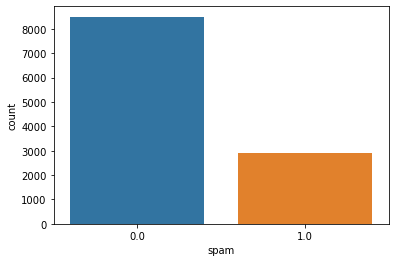

In [38]:
sns.countplot(x='spam', data=data_vi)
plt.show()

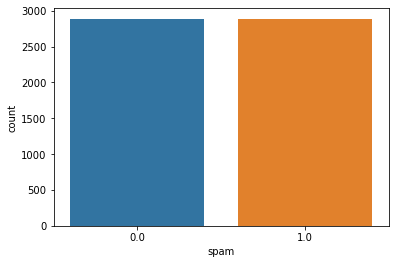

In [39]:

ham_msg = data_vi[data_vi.spam == 0]
spam_msg = data_vi[data_vi.spam == 1]
ham_msg = ham_msg.sample(n = len(spam_msg), random_state = 42)
    

balanced_data = pd.concat([ham_msg, spam_msg], ignore_index = True)

sns.countplot(x='spam', data=balanced_data)
plt.show()

In [40]:
balanced_data['text'] = balanced_data['text'].apply(lambda text: standard_data.standard_vi(text))

In [41]:
balanced_data

,spam,text
0,0.0,ước sản xuất 7 daren fyi bob tiếp robert cotte...
1,0.0,thức dậy dunno
2,0.0,takin vòi hoa sen rời đi hoàn thành
3,0.0,hahaha não thân yêu
4,0.0,k chăm sóc
...,...,...
5771,1.0,chiến thắng may mắn rút thăm trúng thưởng coca...
5772,1.0,gỡ tâm giao trực tuyến hôm
5773,1.0,kiếm tiền chóng
5774,1.0,cửa


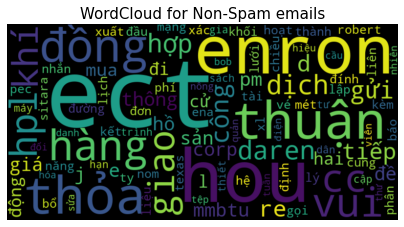

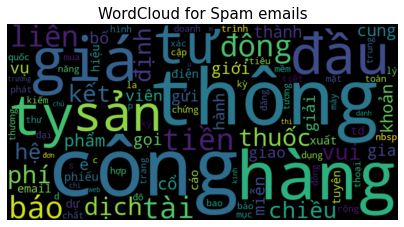

In [42]:
def plot_word_cloud(data, typ):
    email_corpus = " ".join(data['text'])
 
    plt.figure(figsize=(7, 7))
 
    wc = WordCloud(background_color='black',
                   max_words=100,
                   width=800,
                   height=400,
                   collocations=False).generate(email_corpus)
 
    plt.imshow(wc, interpolation='bilinear')
    plt.title(f'WordCloud for {typ} emails', fontsize=15)
    plt.axis('off')
    plt.show()
 
plot_word_cloud(balanced_data[balanced_data['spam'] == 0], typ='Non-Spam')
plot_word_cloud(balanced_data[balanced_data['spam'] == 1], typ='Spam')

In [43]:
train_X, test_X, train_Y, test_Y = train_test_split(balanced_data['text'],
                                                        balanced_data['spam'],
                                                        test_size = 0.2,
                                                        random_state = 42)



In [44]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_X)

In [45]:
train_sequences = tokenizer.texts_to_sequences(train_X)
test_sequences = tokenizer.texts_to_sequences(test_X)

In [46]:
max_len = 100 # độ dài tối đa
train_sequences = pad_sequences(train_sequences, maxlen = max_len, padding = 'post', truncating = 'post')
test_sequences = pad_sequences(test_sequences, maxlen = max_len, padding = 'post', truncating = 'post')

In [47]:
print(train_sequences)
train_sequences.shape

[[  485    72   566 ...  4572   301   105]
 [ 7073   547     9 ...     0     0     0]
 [ 4579  1200 11158 ...     0     0     0]
 ...
 [  376    21   153 ...     0     0     0]
 [   25    60   836 ...     0     0     0]
 [  525  2469    24 ...     0     0     0]]


(4620, 100)

In [48]:
print(test_sequences)
test_sequences.shape

[[  662   731   271 ...     0     0     0]
 [   70   327   416 ...     0     0     0]
 [  945   341  3769 ...  6221  1068 28658]
 ...
 [  562   115   771 ...  2115     6     1]
 [   90   232   103 ...     1    61   259]
 [   11   285    63 ...     0     0     0]]


(1156, 100)

In [49]:
#2.4 Xây dựng và huấn luyện mô hình.
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1,
                                    output_dim=32, 
                                    input_length=max_len))
model.add(tf.keras.layers.LSTM(16))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
 
# Print the model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 32)           989600    
                                                                 
 lstm_2 (LSTM)               (None, 16)                3136      
                                                                 
 dense_4 (Dense)             (None, 32)                544       
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 993313 (3.79 MB)
Trainable params: 993313 (3.79 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [50]:
model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
                metrics = ['accuracy'],
                optimizer = 'adam')


es = EarlyStopping(patience=3,
                    monitor = 'val_accuracy',
                    restore_best_weights = True)

lr = ReduceLROnPlateau(patience = 2,
                        monitor = 'val_loss',
                        factor = 0.5,
                        verbose = 0)

Epoch 1/20


C:\Users\Admin\AppData\Roaming\Python\Python39\site-packages\keras\src\backend.py:5820: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


145/145 [==============================] - 8s 44ms/step - loss: 0.6769 - accuracy: 0.5424 - val_loss: 0.6498 - val_accuracy: 0.6194 - lr: 0.0010
Epoch 2/20
145/145 [==============================] - 6s 41ms/step - loss: 0.5129 - accuracy: 0.7766 - val_loss: 0.5925 - val_accuracy: 0.6903 - lr: 0.0010
Epoch 3/20
145/145 [==============================] - 8s 56ms/step - loss: 0.4725 - accuracy: 0.8041 - val_loss: 0.4842 - val_accuracy: 0.8149 - lr: 0.0010
Epoch 4/20
145/145 [==============================] - 8s 55ms/step - loss: 0.4025 - accuracy: 0.8600 - val_loss: 0.4780 - val_accuracy: 0.8209 - lr: 0.0010
Epoch 5/20
145/145 [==============================] - 8s 56ms/step - loss: 0.3863 - accuracy: 0.8671 - val_loss: 0.4730 - val_accuracy: 0.8227 - lr: 0.0010
Epoch 6/20
145/145 [==============================] - 9s 59ms/step - loss: 0.4204 - accuracy: 0.8342 - val_loss: 0.5481 - val_accuracy: 0.7067 - lr: 0.0010
Epoch 7/20
145/145 [==============================] - 9s 62ms/step - loss: 

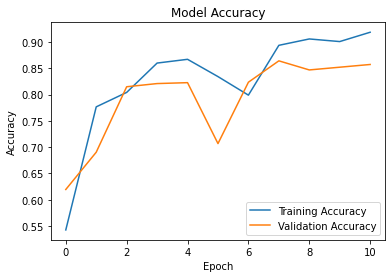

In [51]:
history = model.fit(train_sequences, train_Y,
                    validation_data=(test_sequences, test_Y),
                    epochs=20, 
                    batch_size=32,
                    callbacks = [lr, es]
                   )


test_loss, test_accuracy = model.evaluate(test_sequences, test_Y)
print('Test Loss :',test_loss)
print('Test Accuracy :',test_accuracy)

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()